In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/CUBS/Code/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/cloudy_grids/'

Obtain the UVB grid from FG20

In [4]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [5]:
z_test = 1

In [6]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify $N_{\mathrm{HI}}$ grid points and get corresponding filenames

In [7]:
logN_HI_min_main = 12
logN_HI_max_main = 17
logN_HI_step_main = 0.25

logN_HI_arr_main = np.arange(logN_HI_min_main, logN_HI_max_main+logN_HI_step_main, logN_HI_step_main)

In [8]:
file_list_main = create_grid_file_list(logN_HI_arr_main)

Specify grid points for densities and metallicities

In [9]:
log_hdens_min_main = -5
log_hdens_max_main = 1
log_hdens_step_main = 0.25

log_hdens_arr_main = np.arange(log_hdens_min_main, log_hdens_max_main+log_hdens_step_main, log_hdens_step_main)

In [10]:
log_metals_min_main = -3
log_metals_max_main = 1
log_metals_step_main = 0.25

log_metals_arr_main = np.arange(log_metals_min_main, log_metals_max_main+log_metals_step_main, log_metals_step_main)

In [11]:
# Total number of grid points
len(logN_HI_arr_main)*len(log_hdens_arr_main)*len(log_metals_arr_main)

8925

Process the grid to identify "failures"

In [12]:
log_T_pie_thresh = 4

In [13]:
# Bifurcate failures based on stopping temperature
low_temp_failures = []
high_temp_failures = []

In [14]:
for i in range(len(logN_HI_arr_main)):
    
    logN_HI = logN_HI_arr_main[i]
    
    # The filename corresponding to the current stopping HI column density
    filename = file_list_main[i]
    
    # Get list of densities and metallicities for this stopping HI column density 
    log_hdens_grid, log_metals_grid = read_grd_file(rootdir+'main_grid/', filename)
    
    # Get average (log) HI temperatures for all grid points
    log_temps_grid = read_avr_file(rootdir+'main_grid/', filename)
    
    # Get column densities for all species
    species_names, log_col_dens_grid = read_col_file(rootdir+'main_grid/', filename)
    
    for j in range(len(log_hdens_arr_main)):
        
        log_hdens = log_hdens_arr_main[j]
        
        for k in range(len(log_metals_arr_main)):
            
            log_metals = log_metals_arr_main[k]
            
            # Get grid index number for the current n_H and metallicity
            idx = np.intersect1d(np.where(log_hdens_grid==log_hdens)[0], np.where(log_metals_grid==log_metals)[0])[0]
            
            # Isolate the average temperature and column density for all species
            log_temp = log_temps_grid[idx]
            log_col_dens = log_col_dens_grid[idx]
            
            # Check if this grid point is a failure
            if np.round(log_col_dens[0],2) != logN_HI:
                # Categorize based on temperature
                if log_temp<log_T_pie_thresh:
                    low_temp_failures.append([logN_HI, log_hdens, log_metals, log_temp, log_col_dens[0]])
                else:
                    high_temp_failures.append([logN_HI, log_hdens, log_metals, log_temp, log_col_dens[0]])

/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:429: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:429: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:429: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:429: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:429: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(co

In [15]:
low_temp_failures = np.array(low_temp_failures)
high_temp_failures = np.array(high_temp_failures)

In [16]:
len(low_temp_failures)

1547

In [17]:
len(high_temp_failures)

25

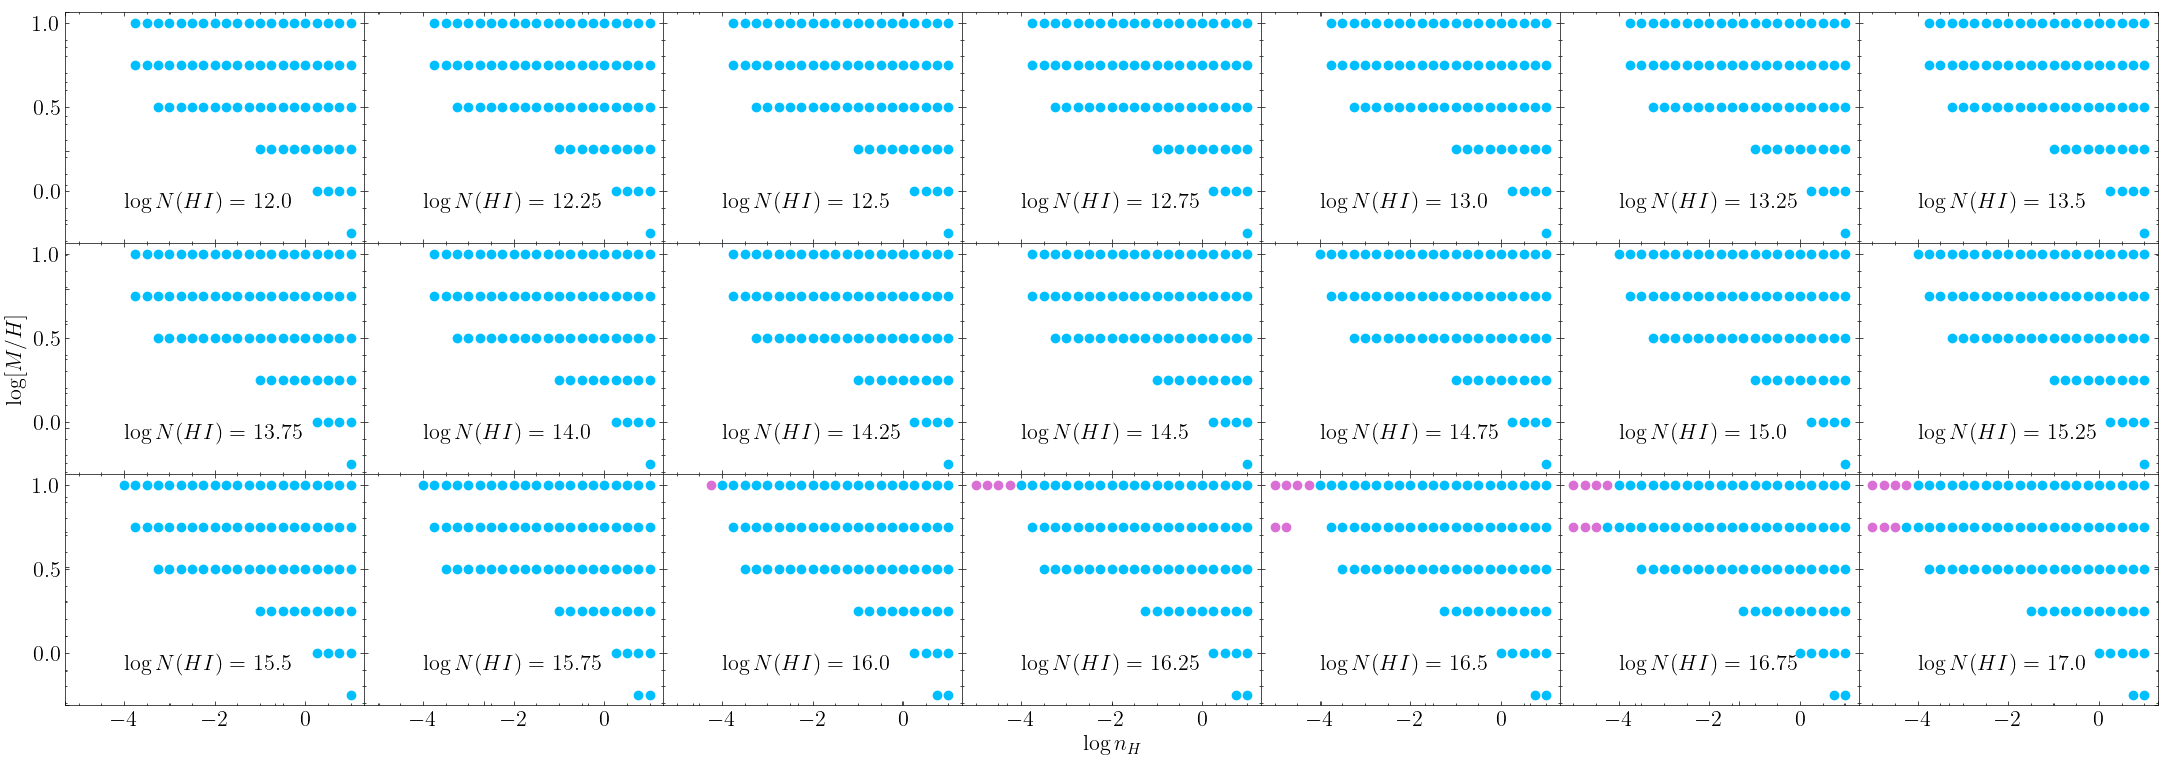

In [18]:
fig, axes = plt.subplots(3, 7, figsize=(27, 9), sharex=True, sharey=True)

for i in range(len(np.unique(low_temp_failures[:,0]))):
    
    row = i//7
    col = i%7
    
    ax = axes[row, col]
    
    logN_HI_stop = np.unique(low_temp_failures[:,0])[i]
    
    idx = (low_temp_failures[:,0] == logN_HI_stop)
    ax.scatter(low_temp_failures[idx][:,1], low_temp_failures[idx][:,2], color='deepskyblue')
    
    idx_hi = (high_temp_failures[:,0] == logN_HI_stop)
    
    if np.sum(idx_hi)!=0:
        ax.scatter(high_temp_failures[idx_hi][:,1], high_temp_failures[idx_hi][:,2], color='orchid')
    
    ax.text(x=-4, y=-.1, s=r'$\log N (HI) = $ {}'.format(logN_HI_stop))
    
ax_label = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

ax_label.set_xlabel(r'$\log n_H$')
ax_label.set_ylabel(r'$\log [M/H]$')

plt.subplots_adjust(wspace=0, hspace=0) 

Create the FINAL grid, populate it with "successful" candidates from the main grid, DON'T save it yet

In [19]:
species_logN_samples_final = {}
logT_grid_final = np.zeros((len(logN_HI_arr_main), len(log_hdens_arr_main), len(log_metals_arr_main)))

In [20]:
for i in range(len(logN_HI_arr_main)):
    
    logN_HI = logN_HI_arr_main[i]
    
    # The filename corresponding to the current stopping HI column density
    filename = file_list_main[i]
    
    # Get list of densities and metallicities for this stopping HI column density 
    log_hdens_grid, log_metals_grid = read_grd_file(rootdir+'main_grid/', filename)
        
    # Get average (log) HI temperatures for all grid points
    log_temps_grid = read_avr_file(rootdir+'main_grid/', filename)
    
    # Get column densities for all species
    species_names, log_col_dens_grid = read_col_file(rootdir+'main_grid/', filename)
    
    for j in range(len(log_hdens_arr_main)):
        
        log_hdens = log_hdens_arr_main[j]
        
        for k in range(len(log_metals_arr_main)):
            
            log_metals = log_metals_arr_main[k]
            
            # Get grid index number for the current n_H and metallicity
            idx = np.intersect1d(np.where(log_hdens_grid==log_hdens)[0], np.where(log_metals_grid==log_metals)[0])[0]
            # Isolate the average temperature and column density for all species
            log_temp = log_temps_grid[idx]
            logT_grid_final[i,j,k] = log_temp
            log_col_dens = log_col_dens_grid[idx]
            
            # For each species
            for l in range(len(species_names)):
                
                s = species_names[l]
                
                if s not in species_logN_samples_final.keys():
                    
                    species_logN_samples_final[s] = -99.*np.ones((len(logN_HI_arr_main), 
                                                            len(log_hdens_arr_main),
                                                            len(log_metals_arr_main)))
                
                # Check for converged logN(HI)
                if np.round(log_col_dens[0],2) == logN_HI:
                    species_logN_samples_final[s][i,j,k] = log_col_dens[l]

/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:429: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:429: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:429: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:429: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:429: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(co

In [21]:
unique, counts = np.unique(species_logN_samples_final['#column density H'].flatten(), return_counts=True)

In [22]:
counts

array([1572,  353,  353,  353,  346,    7,    1,    1,  351,    1,  352,
          2,  351,    1,    1,  343,    8,    1,    4,  348,    1,  352,
          1,    1,    6,  345,    2,    6,  324,   20,    1,    2,    2,
          2,    4,  125,  216,    8,  342,    2,    1,   10,  178,  160,
          1,    1,    1,    1,    2,    4,   30,  152,  149,    6,    2,
          1,    2,    1,    3,    6,    9,    6,   13,   18,   21,   44,
         58,   93,   72,    4,    1,    1,   10,  109,  218,    3,    2,
          1,    1,    1,   22,  147,   86,   13,   12,    7,    9,   10,
          7,    2,    2,    4,    1,    3,    2,    2,    2,    1,    3,
          2,    1,    2,    1,    1,    1,    1,    1,    1,   41,  131,
         41,   18,   15,   15,   10,    6,   11,    3,    6,    4,    5,
          6,    5,    6,    2,    3,    2,    1,    1,    1,    1,    1,
          1,    9,  224,   59,   26,   15,    2,    1])

Load in the subgrid, fix the low temperature failures

In [23]:
logN_HI_min_sub = 12
logN_HI_max_sub = 17
logN_HI_step_sub = 0.25

logN_HI_arr_sub = np.arange(logN_HI_min_sub, logN_HI_max_sub+logN_HI_step_sub, logN_HI_step_sub)

In [24]:
file_list_sub = create_grid_file_list(logN_HI_arr_sub)

In [25]:
log_hdens_min_sub = -4.25
log_hdens_max_sub = 1
log_hdens_step_sub = 0.25

log_hdens_arr_sub = np.arange(log_hdens_min_sub, log_hdens_max_sub+log_hdens_step_sub, log_hdens_step_sub)

In [26]:
log_metals_min_sub = -0.25
log_metals_max_sub = 1
log_metals_step_sub = 0.25

log_metals_arr_sub = np.arange(log_metals_min_sub, log_metals_max_sub+log_metals_step_sub, log_metals_step_sub)

In [27]:
# Total number of grid points
len(logN_HI_arr_sub)*len(log_hdens_arr_sub)*len(log_metals_arr_sub)

2772

In [28]:
species_logN_samples_sub = {}
logT_grid_sub = np.zeros((len(logN_HI_arr_sub), len(log_hdens_arr_sub), len(log_metals_arr_sub)))

In [29]:
for i in range(len(logN_HI_arr_sub)):
    
    logN_HI = logN_HI_arr_sub[i]
    
    # The filename corresponding to the current stopping HI column density
    filename = file_list_sub[i]
    
    # Get list of densities and metallicities for this stopping HI column density 
    log_hdens_grid, log_metals_grid = read_grd_file(rootdir+'sub_grid/', filename)
    
    # Get average (log) HI temperatures for all grid points
    log_temps_grid = read_avr_file(rootdir+'sub_grid/', filename)
    
    # Get column densities for all species
    species_names, log_col_dens_grid = read_col_file(rootdir+'sub_grid/', filename)
    
    for j in range(len(log_hdens_arr_sub)):
        
        log_hdens = log_hdens_arr_sub[j]
        
        for k in range(len(log_metals_arr_sub)):
            
            log_metals = log_metals_arr_sub[k]
            
            # Get grid index number for the current n_H and metallicity
            idx = np.intersect1d(np.where(log_hdens_grid==log_hdens)[0], np.where(log_metals_grid==log_metals)[0])[0]
            
            # Isolate the average temperature and column density for all species
            log_temp = log_temps_grid[idx]
            logT_grid_sub[i,j,k] = log_temp
            
            log_col_dens = log_col_dens_grid[idx]
            
            # For each species
            for l in range(len(species_names)):
                
                s = species_names[l]
                
                if s not in species_logN_samples_sub.keys():
                    
                    species_logN_samples_sub[s] = -99.*np.ones((len(logN_HI_arr_sub), 
                                                            len(log_hdens_arr_sub),
                                                            len(log_metals_arr_sub)))
                
                # Check for converged logN(HI)
                if np.round(log_col_dens[0],2) == logN_HI:
                    species_logN_samples_sub[s][i,j,k] = log_col_dens[l]

/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:429: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:429: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:429: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:429: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:429: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(co

Index the low temperature failures in the final grid, and fix them using the indices from the subgrid

In [30]:
# Consider a low temperature failure
for f in range(len(low_temp_failures)):

    # Register the "coordinates" of the failed grid point
    logN_HI = low_temp_failures[f][0]
    log_hdens = low_temp_failures[f][1]
    log_metals = low_temp_failures[f][2]

    # Get indices for the grid point in the main grid
    idx_logN_HI_main = np.where(logN_HI_arr_main==logN_HI)[0][0]
    idx_log_hdens_main = np.where(log_hdens_arr_main==log_hdens)[0][0]
    idx_log_metals_main = np.where(log_metals_arr_main==log_metals)[0][0]

    # Get indices for the grid point in the subgrid
    idx_logN_HI_sub = np.where(logN_HI_arr_sub==logN_HI)[0][0]
    idx_log_hdens_sub = np.where(log_hdens_arr_sub==log_hdens)[0][0]
    idx_log_metals_sub = np.where(log_metals_arr_sub==log_metals)[0][0]
    
    # For each species
    for l in range(len(species_logN_samples_final)):

        s = list(species_logN_samples_final.keys())[l]
        # Set the temperature column density for the species in the final grid to that taken from the subgrid
        logT_grid_final[idx_logN_HI_main,idx_log_hdens_main,idx_log_metals_main] = logT_grid_sub[idx_logN_HI_sub,idx_log_hdens_sub,idx_log_metals_sub]
        species_logN_samples_final[s][idx_logN_HI_main, idx_log_hdens_main, idx_log_metals_main] = species_logN_samples_sub[s][idx_logN_HI_sub, idx_log_hdens_sub, idx_log_metals_sub]

In [31]:
unique, counts = np.unique(species_logN_samples_final['#column density H'].flatten(), return_counts=True)

In [32]:
counts

array([ 25, 425, 425, 425, 418,   7,   1,   1, 423,   1, 424,   2, 423,
         1,   1, 415,   8,   1,   4, 420,   1, 424,   1,   1,   6, 417,
         2,   6, 397,  20,   1,   2,   2,   2,   4, 159, 255,   8, 415,
         2,   1,  10, 223, 188,   1,   1,   1,   1,   2,   4,  30, 193,
       183,   6,   2,   1,   2,   1,   3,   6,   9,   8,  14,  21,  27,
        59,  79, 117,  75,   4,   1,   1,  10, 130, 273,   3,   2,   1,
         1,   1,  22, 216,  94,  13,  12,   7,   9,  10,   7,   2,   2,
         4,   1,   3,   2,   2,   2,   1,   3,   2,   1,   2,   1,   1,
         1,   1,   1,   1,  52, 181,  57,  20,  15,  15,  10,   6,  11,
         3,   6,   4,   5,   6,   5,   6,   2,   3,   2,   1,   1,   1,
         1,   1,   1,  12, 293,  66,  28,  15,   2,   1])

Load in the extraneous grid, fix the high temperature failures

In [33]:
grid_points_ext = np.array([[16.  , -4.25,  1.  ],
       [16.25, -5.  ,  1.  ],
       [16.25, -4.75,  1.  ],
       [16.25, -4.5 ,  1.  ],
       [16.25, -4.25,  1.  ],
       [16.5 , -5.  ,  0.75],
       [16.5 , -5.  ,  1.  ],
       [16.5 , -4.75,  0.75],
       [16.5 , -4.75,  1.  ],
       [16.5 , -4.5 ,  1.  ],
       [16.5 , -4.25,  1.  ],
       [16.75, -5.  ,  0.75],
       [16.75, -5.  ,  1.  ],
       [16.75, -4.75,  0.75],
       [16.75, -4.75,  1.  ],
       [16.75, -4.5 ,  0.75],
       [16.75, -4.5 ,  1.  ],
       [16.75, -4.25,  1.  ],
       [17.  , -5.  ,  0.75],
       [17.  , -5.  ,  1.  ],
       [17.  , -4.75,  0.75],
       [17.  , -4.75,  1.  ],
       [17.  , -4.5 ,  0.75],
       [17.  , -4.5 ,  1.  ],
       [17.  , -4.25,  1.  ]])

In [34]:
len(grid_points_ext)

25

In [35]:
species_logN_samples_ext = {}
logT_ext_grid = np.zeros(len(grid_points_ext))

In [36]:
for i in range(len(grid_points_ext)):
    
    logN_HI, log_hdens, log_metals = grid_points_ext[i]
    
    # The filename corresponding to this grid point
    
    logN_HI_str = '{:.2f}'.format(logN_HI).replace('.','')
    log_hdens_str = '{:.2f}'.format(log_hdens).replace('.','')
    log_metals_str = '{:.2f}'.format(log_metals).replace('.','')
    
    filename = 'igm_lalpha_hm12_grid_{}_{}_{}'.format(logN_HI_str, log_hdens_str, log_metals_str)
    
    # Get average (log) HI temperatures for all grid points
    log_temp = read_avr_file(rootdir+'ext_grid/', filename)[0]
    logT_ext_grid[i] = log_temp
    
    # Get column densities for all species
    species_names, log_col_dens_grid = read_col_file(rootdir+'ext_grid/', filename)
    log_col_dens = log_col_dens_grid[0]

    # For each species
    for l in range(len(species_names)):

        s = species_names[l]

        if s not in species_logN_samples_ext.keys():
            species_logN_samples_ext[s] = -99.*np.ones(len(grid_points_ext))
            
        # Check for converged logN(HI)
        if np.round(log_col_dens[0],2) == logN_HI:
            species_logN_samples_ext[s][i] = log_col_dens[l]

Index the high temperature failures in the final grid, and fix them using the indices from the extraneous grid

In [37]:
# For each species
for l in range(len(species_logN_samples_final)):
    
    s = list(species_logN_samples_final.keys())[l]
    
    # Consider a high temperature failure
    # These exactly grid_points_ext (excepting any extra column)
    for f in range(len(high_temp_failures)):
        
        # Register the "coordinates" of the failed grid point
        logN_HI = high_temp_failures[f][0]
        log_hdens = high_temp_failures[f][1]
        log_metals = high_temp_failures[f][2]
        
        # Get indices for the grid point in the main grid
        idx_logN_HI_main = np.where(logN_HI_arr_main==logN_HI)[0]
        idx_log_hdens_main = np.where(log_hdens_arr_main==log_hdens)[0]
        idx_log_metals_main = np.where(log_metals_arr_main==log_metals)[0]
        
        # Set the temperature column density for the species in the final grid to that taken from the subgrid
        logT_grid_final[idx_logN_HI_main, idx_log_hdens_main, idx_log_metals_main] = logT_ext_grid[f]
        species_logN_samples_final[s][idx_logN_HI_main, idx_log_hdens_main, idx_log_metals_main] = species_logN_samples_ext[s][f]

At this point, all final grid points should be fixed, a.k.a. have no "99s"

In [38]:
np.unique(species_logN_samples_final['#column density H'])

array([12.        , 12.25000014, 12.50000032, 12.74999975, 12.75000052,
       12.99999913, 12.99999957, 13.        , 13.2499977 , 13.25000014,
       13.49999895, 13.50000032, 13.74999666, 13.74999898, 13.74999975,
       13.75000052, 13.99999913, 13.99999957, 14.        , 14.2499977 ,
       14.25000014, 14.4999962 , 14.49999757, 14.49999895, 14.50000032,
       14.7499982 , 14.74999898, 14.74999975, 14.75000052, 14.99999566,
       14.99999783, 14.99999826, 14.9999987 , 14.99999913, 14.99999957,
       15.        , 15.2499977 , 15.25000014, 15.25000259, 15.4999962 ,
       15.49999757, 15.49999895, 15.50000032, 15.50000444, 15.50000581,
       15.50000719, 15.74999589, 15.74999666, 15.74999743, 15.7499982 ,
       15.74999898, 15.74999975, 15.75000052, 15.75000129, 15.75000207,
       15.75000824, 15.75001288, 15.99999566, 15.99999609, 15.99999653,
       15.99999696, 15.99999739, 15.99999783, 15.99999826, 15.9999987 ,
       15.99999913, 15.99999957, 16.        , 16.00000434, 16.00

In [39]:
np.unique(np.round(species_logN_samples_final['#column density H'], 2)) == logN_HI_arr_main

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

Save the final column density grid

In [40]:
output = open(rootdir+'final_grid.pkl', 'wb')
pickle.dump(species_logN_samples_final, output)
output.close()

Save the flattened temperature grid - will have to be reshaped upon loading

In [41]:
np.savetxt(rootdir+'final_flat_logT.dat', logT_grid_final.flatten())

Save ion fractions

In [42]:
species_fracs_samples_final = {s:np.zeros((len(logN_HI_arr_main),len(log_hdens_arr_main),len(log_metals_arr_main))) for s in species_names_ions}

In [43]:
# H fractions
N_H_grid_final = 10**species_logN_samples_final['#column density H']+10**species_logN_samples_final['H+']
species_fracs_samples_final['#column density H'] = 10**species_logN_samples_final['#column density H']/N_H_grid_final
species_fracs_samples_final['H+'] = 10**species_logN_samples_final['H+']/N_H_grid_final

In [44]:
N_He_grid_final = 10**species_logN_samples_final['He']+10**species_logN_samples_final['He+']+10**species_logN_samples_final['He+2']
species_fracs_samples_final['He'] = 10**species_logN_samples_final['He']/N_He_grid_final
species_fracs_samples_final['He+'] = 10**species_logN_samples_final['He+']/N_He_grid_final
species_fracs_samples_final['He+2'] = 10**species_logN_samples_final['He+2']/N_He_grid_final

In [45]:
# Grid of metallicities

log_metals_grid_final = np.zeros((len(logN_HI_arr_main),len(log_hdens_arr_main),len(log_metals_arr_main)))

for i in range(len(logN_HI_arr_main)):
    for j in range(len(log_hdens_arr_main)):
        log_metals_grid_final[i,j,:] = log_metals_arr_main
        
for i in range(5,len(species_names_ions)):
    s = species_names_ions[i]
    species_fracs_samples_final[s] = 10**species_logN_samples_final[s]/(N_H_grid_final*10**log_metals_grid_final)

In [46]:
species_logf_samples_final = {s:np.log10(species_fracs_samples_final[s]) for s in list(species_fracs_samples_final.keys())}

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_14413/2521897642.py:1: RuntimeWarning: divide by zero encountered in log10
  species_logf_samples_final = {s:np.log10(species_fracs_samples_final[s]) for s in list(species_fracs_samples_final.keys())}


In [47]:
output = open(rootdir+'final_grid_logf.pkl', 'wb')
pickle.dump(species_logf_samples_final, output)
output.close()

In [50]:
#species_logf_samples_final['C+3']